# Import Model

In [1]:
import torch
import torch.nn as nn


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, negative_slope=0.01):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.LeakyReLU(negative_slope)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2   = nn.BatchNorm2d(out_channels)

        # 如果 in_channels != out_channels 或 stride != 1，就需要用 1×1 conv 來對齊維度/尺寸
        self.shortcut = None
        if (stride != 1) or (in_channels != out_channels):
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        
        self.relu2 = nn.LeakyReLU(negative_slope)

    def forward(self, x):
        identity = x  # 先把輸入保留下來

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # 如果需要調整通道或stride，就用shortcut
        if self.shortcut is not None:
            identity = self.shortcut(x)

        # 將殘差 (out) 與 identity 相加
        out += identity  
        out = self.relu2(out)
        return out
    
class ResNetLikeEncoder(nn.Module):
    def __init__(self, out_dim, in_channels=3, negative_slope=0.01):
        super().__init__()
        # 第一段：輸入後馬上下採樣
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(negative_slope),
            nn.MaxPool2d(kernel_size=2)
        )
        # 第二段：殘差塊 x2，調通道 16 → 32
        self.layer1 = nn.Sequential(
            ResidualBlock(16, 32, stride=1, negative_slope=negative_slope),
            ResidualBlock(32, 32, stride=1, negative_slope=negative_slope),
            nn.MaxPool2d(kernel_size=2)
        )
        # 第三段：殘差塊 x2，調通道 32 → 64
        self.layer2 = nn.Sequential(
            ResidualBlock(32, 64, stride=1, negative_slope=negative_slope),
            ResidualBlock(64, 64, stride=1, negative_slope=negative_slope),
            nn.AdaptiveAvgPool2d((1, 1))  # 池化到 1×1
        )
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(64, out_dim)

    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.linear(x)
        return x


class MLPDecoder(nn.Module):
    def __init__(self, input_dim, output_dim=35, negative_slope=0.01):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(negative_slope),
            nn.Dropout(p=0.1),  # 調整 dropout 至 0.1
            nn.Linear(128, 64),
            nn.LeakyReLU(negative_slope),
            nn.Dropout(p=0.1),   # 調整 dropout 至 0.1
            nn.Linear(64, output_dim)  # 👉 Linear activation
        )
        # 每個 head 對應一個 cell type 的輸出

    def forward(self, x):
        outs = self.shared(x)
        # 將所有 head 的輸出合併成 (B, output_dim)
        return outs



class VisionMLP_MultiTask(nn.Module):
    def __init__(self, cnn_out_dim=64, output_dim=35, negative_slope=0.01):
        super().__init__()
        self.encoder_tile = ResNetLikeEncoder(cnn_out_dim, in_channels=3, negative_slope=negative_slope)
        self.encoder_neighbors = ResNetLikeEncoder(cnn_out_dim, in_channels=3, negative_slope=negative_slope)
        self.encoder_subtiles = ResNetLikeEncoder(cnn_out_dim, in_channels=3, negative_slope=negative_slope)

        # 注意這裡更新 decoder 的 input_dim，如果不需要坐標可以另外調整
        self.decoder = MLPDecoder(input_dim=cnn_out_dim * 3 + 2,
                                  output_dim=output_dim,
                                  negative_slope=negative_slope)

    def forward(self, tile, subtiles, neighbors, norm_coord):
        B = tile.size(0)

        # tile: [B, 3, 78, 78]
        f_tile = self.encoder_tile(tile)

        # subtiles: [B, 9, 3, 26, 26]
        B, N, C, H, W = subtiles.shape
        subtiles_reshaped = subtiles.contiguous().reshape(B * N, C, H, W)
        f_sub = self.encoder_subtiles(subtiles_reshaped).reshape(B, N, -1).mean(dim=1)

        # neighbors: [B, 8, 3, 78, 78]
        B, N, C, H, W = neighbors.shape
        neighbors_reshaped = neighbors.contiguous().reshape(B * N, C, H, W)
        f_neigh = self.encoder_neighbors(neighbors_reshaped).reshape(B, N, -1).mean(dim=1)

        x = torch.cat([f_tile, f_sub, f_neigh, norm_coord], dim=1)
        return self.decoder(x)






model = VisionMLP_MultiTask()

## Load Model

In [ ]:

from python_scripts.import_model import load_model_classes
from python_scripts.operate_model import get_model_inputs

# ==============================================
# 範例使用
# ==============================================
folder = "./output_folder/CNN+MLP/"  # 替換成實際的資料夾路徑，該路徑下應有 model.py
try:
    loaded_classes = load_model_classes(folder)
    print("載入的 class 名稱:", list(loaded_classes.keys()))
except Exception as e:
    print("載入模型 class 發生錯誤:", e)    


In [ ]:
# 假設 loaded_classes 是你已經從 model.py 載入的 class 字典
name_of_class = 'VisionMLPModelWithCoord'
ModelClass = loaded_classes.get(name_of_class)
if ModelClass is None:
    raise ValueError(f"找不到 {name_of_class} 這個 class")
# 這裡呼叫 ModelClass() 建立實例，注意不能直接用 name_of_class() (因為它是一個字串)
model = ModelClass()  # 如果需要參數，請在此處傳入
get_model_inputs(model)
#print("建立的模型實例:", model)


# Import training data

## Same in multiple .pt

In [2]:
import os
import torch
import random
import inspect
from python_scripts.import_data import load_all_tile_data

# 用法範例
folder = "./dataset/spot-rank/version-1/node_features_train"
grouped_data = load_all_tile_data(
        folder_path=folder,
        model=model,
        fraction=0.1,
        shuffle=False
    )

    # grouped_data 現在只會有 model.forward() 需要的 key，
    # 像 ['tile','subtiles','neighbors','norm_coord','node_feat','adj_list','edge_feat','label','source_idx']
print("Loaded keys:", grouped_data.keys())
print("Samples:", len(next(iter(grouped_data.values()))))


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <FB2FD416-6C4D-3621-B677-61F07C02A3C5> /opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/spatialhackathon

✅ Using device: mps


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/Users/deweywang/Desktop/GitHub/HEVisum/python_scripts/import_data.py:299: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.seria

Loaded keys: dict_keys(['source_idx', 'tile', 'subtiles', 'label', 'norm_coord', 'neighbors'])
Samples: 3272


In [3]:
from python_scripts.import_data import importDataset

image_keys = ['neighbors', 'tile', 'subtiles']

train_dataset = importDataset(
        data_dict=grouped_data,
        model=model,
        image_keys=image_keys,
        transform=lambda x: x,  # identity transform
        print_sig=True
    )

Model forward signature: (tile, subtiles, neighbors, norm_coord)


In [5]:
train_dataset.check_item(1000, 10)


🔍 Checking dataset sample: 1000
📏 tile shape: torch.Size([3, 78, 78]) | dtype: torch.float32 | min: 0.000, max: 0.988, mean: 0.351, std: 0.384
📏 subtiles shape: torch.Size([9, 3, 26, 26]) | dtype: torch.float32 | min: 0.000, max: 0.988, mean: 0.351, std: 0.384
📏 neighbors shape: torch.Size([8, 3, 78, 78]) | dtype: torch.float32 | min: 0.000, max: 1.000, mean: 0.335, std: 0.373
📏 norm_coord shape: torch.Size([2]) | dtype: torch.float32 | min: 0.245, max: 0.350, mean: 0.298, std: 0.075
--- norm_coord head (前 10 個元素):
tensor([0.3502, 0.2448])
📏 label shape: torch.Size([35]) | dtype: torch.float32 | min: 1.000, max: 35.000, mean: 18.000, std: 10.247
--- label head (前 10 個元素):
tensor([16., 32., 23., 20., 35., 15., 30.,  6., 21., 10.])
✅ All checks passed!


In [4]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader

# 設定比例
train_ratio = 0.8
val_ratio = 1 - train_ratio
total_len = len(train_dataset)
train_len = int(train_ratio * total_len)
val_len = total_len - train_len

# 拆分 Dataset
generator = torch.Generator().manual_seed(42)
train_set, val_set = random_split(train_dataset, [train_len, val_len], generator=generator)

print(f"✅ Train: {len(train_set)} samples")
print(f"✅ Val: {len(val_set)} samples")

# 🔹 將其包成 DataLoader
BATCH_SIZE = 32

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)


✅ Train: 2617 samples
✅ Val: 655 samples


# Save in one pt

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
from python_scripts.import_data import importDataset, preprocess_data
from torch.utils.data import DataLoader
from torchvision import transforms

# 載入資料
#tile = torch.load("./dataset/final_data/M_tiles.pt")
#subtiles = torch.load("./train_dataset_sep_v2/subtiles.pt")
#neighbor_tiles = torch.load("./train_dataset_sep_v2/neighbor_tiles.pt")
#label = torch.load("./dataset/final_data/gu_log2_labels.pt")
#meta = torch.load("./dataset/final_data/meta_info.pt")



raw_coords = []
for _meta in grouped_data['coords']:
    if _meta is not None:
         x, y = _meta
    else:
        x, y = 0, 0
    raw_coords.append([x, y])

raw_coords = np.array(raw_coords)


coord_scaler = StandardScaler()
normalized_coords = coord_scaler.fit_transform(raw_coords)

train_dataset = {
        'tile': tile,
        #'subtiles': subtiles,
        #'neighbor_tiles': neighbor_tiles,
        'coords': normalized_coords,
        'label': label
    }

my_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
    ])

image_keys = ['tile']

#processed_data = preprocess_data(train_dataset, image_keys, my_transform)

train_dataset = importDataset(
        data_dict=train_dataset,
        model=model,
        image_keys=image_keys,
        transform=lambda x: x,  # identity transform
        print_sig=True
    )

In [ ]:
train_dataset = importDataset(
        data_dict=processed_data,
        model=model,
        image_keys=image_keys,
        transform=lambda x: x,  # identity transform
        print_sig=True
        )

In [ ]:
train_dataset.check_item(1000, 10)


In [ ]:
from torch.utils.data import random_split

# 設定比例
train_ratio = 0.8
val_ratio = 1 - train_ratio
total_len = len(train_dataset)
train_len = int(train_ratio * total_len)
val_len = total_len - train_len

# 拆分 Dataset
generator = torch.Generator().manual_seed(42)
train_set, val_set = random_split(train_dataset, [train_len, val_len], generator=generator)

print(f"✅ Train: {len(train_set)} samples")
print(f"✅ Val: {len(val_set)} samples")

# 🔹 將其包成 DataLoader
BATCH_SIZE = 32

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)


#  Train model

In [8]:
import os
import torch
import csv
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from python_scripts.operate_model import train_one_epoch, evaluate, predict, EarlyStopping, plot_losses, plot_per_cell_metrics
import torch.nn as nn

# ---------------------------
# 指定儲存資料夾
# ---------------------------
save_folder = "output_folder/rank-spot/CNN+Res+MLP_version-1/with_coords_features/no_L2/all_coor_only/margin_ranking_loss/"  # 修改為你想要的資料夾名稱
if not os.path.exists(save_folder):
    os.makedirs(save_folder)


Epoch 32/150 | loss: 21.2537 | val_loss: 27.0843 | lr: 1.00e-04
train spearman: 0.6784 | Val spearman: 0.7062 | ρ: 0.7062


<Figure size 640x480 with 0 Axes>

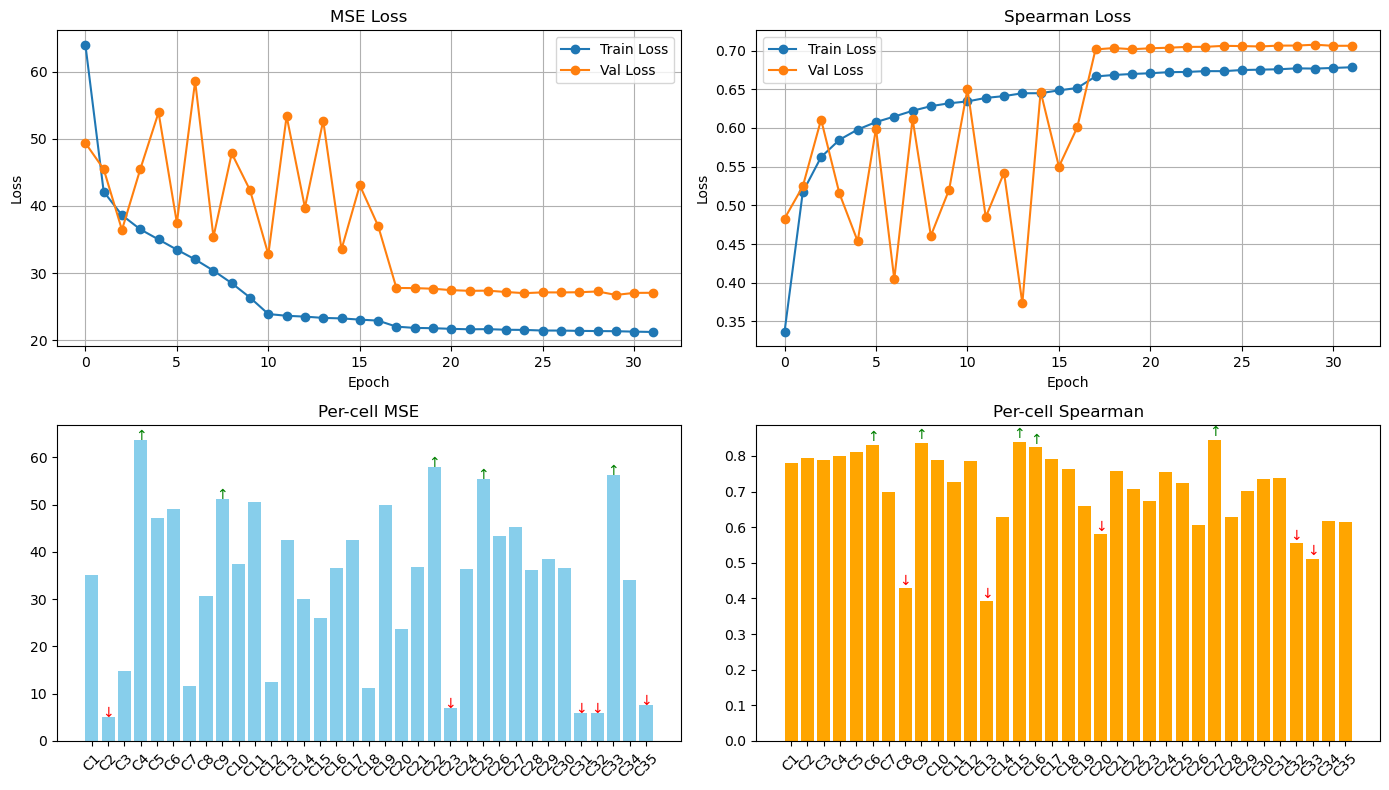

曲線圖已儲存至 output_folder/rank-spot/CNN+Res+MLP_version-1/with_coords_features/no_L2/all_coor_only/margin_ranking_loss/loss_curve.png
EarlyStopping counter: 2/10


KeyboardInterrupt: 

In [7]:
# ---------------------------
# 🔧 設定裝置
# ---------------------------
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"✅ Using device: {device}")

# ---------------------------
# 初始化模型 & 優化器
# ---------------------------
model = model.to(device)
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#loss_fn = lambda pred, tgt: hybrid_weighted_spearman_loss(pred, tgt, alpha=0.5, beta=1.0)

#loss_fn = nn.MSELoss()
# loss_fn = spearman_loss
#LOSS_TYPE = "weighted_mse"  # 或 "mse", "mae", "spearman"

import torch

HARD_IDX = [7, 12, 19, 31, 32]
WEIGHT_VEC = torch.ones(35)
WEIGHT_VEC[HARD_IDX] = 5.0
WEIGHT_VEC = WEIGHT_VEC.to(device)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
early_stopper = EarlyStopping(patience=10)

# ---------------------------
# 儲存 log 的設定
# ---------------------------
log_path = os.path.join(save_folder, "training_log.csv")
log_file = open(log_path, mode="w", newline="")
csv_writer = csv.writer(log_file)
csv_writer.writerow(["Epoch", "Train Loss", "Val Loss", "Val Spearman", "Learning Rate"])

# ---------------------------
# 用來畫圖的變數
# ---------------------------
train_losses = []
val_losses = []
train_spearmanes = []
val_spearmanes = []

# ---------------------------
# 指定最佳模型儲存路徑
# ---------------------------
best_model_path = os.path.join(save_folder, "best_model.pt")
loss_plot_path = os.path.join(save_folder, "loss_curve.png")

# ---------------------------
# 開始訓練
# ---------------------------
num_epochs = 150
best_val_loss = 0
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
display(fig)  # 初始顯示圖形


for epoch in range(num_epochs):
    train_loss, train_spearman = train_one_epoch(model, train_loader, optimizer, device,alpha = 3, hard_idx = HARD_IDX,current_epoch= epoch,initial_alpha=0, final_alpha=1,target_epoch = 10 )
    val_loss, val_spearman, mse_per_cell, spearman_per_cell = evaluate(model, val_loader, device,alpha = 3, hard_idx = HARD_IDX, current_epoch= epoch,initial_alpha=0, final_alpha=1, target_epoch =10)
    clear_output(wait=True)  # 清除之前的輸出
    axes[0][0].clear()
    axes[0][1].clear()
    axes[1][0].clear()
    axes[1][1].clear()
    # 儲存最佳模型
    if best_val_loss < val_spearman:
        best_val_loss = val_spearman
        torch.save(model.state_dict(), best_model_path)
        print("✅ Saved best model!")
        

    # 調整學習率
    scheduler.step(val_loss)

    # 寫入 CSV log
    lr = optimizer.param_groups[0]['lr']
    csv_writer.writerow([epoch + 1, train_loss, val_loss, val_spearman, lr])

    # 印出 Epoch 結果
    print(f"Epoch {epoch + 1}/{num_epochs} | loss: {train_loss:.4f} | val_loss: {val_loss:.4f} | lr: {lr:.2e}")
    print(f"train spearman: {train_spearman:.4f} | Val spearman: {val_spearman:.4f} | ρ: {val_spearman:.4f}")

    # 更新 log 列表並畫圖
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_spearmanes.append(train_spearman)
    val_spearmanes.append(val_spearman)
    


    # plot loss
    plot_losses(train_losses, val_losses, ax=axes[0][0], title="MSE Loss")
    plot_losses(train_spearmanes, val_spearmanes, ax=axes[0][1], title="Spearman Loss")

    cell_names = [f"C{i+1}" for i in range(35)]
    # plot per-cell stats
    plot_per_cell_metrics(mse_per_cell, spearman_per_cell,cell_names,
                        ax_mse=axes[1][0], ax_spearman=axes[1][1])
    

    plt.tight_layout()
    plt.show()
    display(fig)
    plt.pause(0.1)  # 暫停以便更新畫面
    fig.savefig(loss_plot_path)
    print(f"曲線圖已儲存至 {loss_plot_path}")

    # Early stopping
    early_stopper(val_loss)
    if early_stopper.early_stop:
        print("⛔ Early stopping triggered.")
        break

# 關閉 CSV log 檔案
log_file.close()

# 儲存最終圖形
plt.close(fig)
print(f"訓練結束，loss 曲線圖已儲存至 {loss_plot_path}")


# Integrated Gradient

In [ ]:
val_set[0]

Model forward signature: (tile, subtiles, neighbors, norm_coord)


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_52645/676787713.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


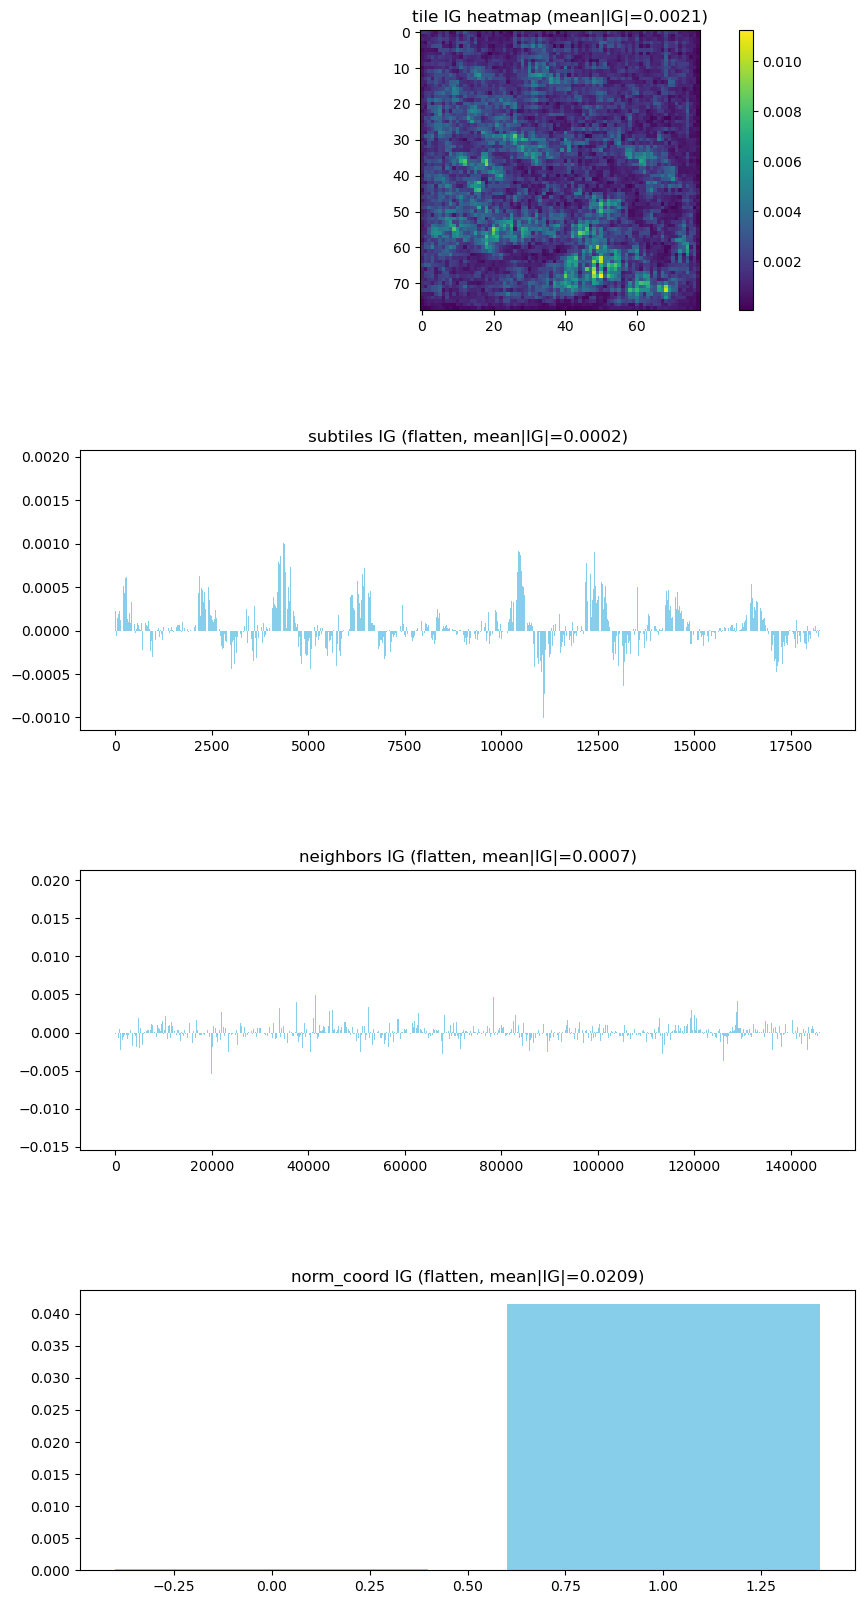


🔑 Mean |IG| Importance Scores:
  tile        : 0.002125
  subtiles    : 0.000162
  neighbors   : 0.000686
  norm_coord  : 0.020905


In [ ]:

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from captum.attr import IntegratedGradients
from python_scripts.operate_model import get_model_inputs

def automate_ig_analysis(model,
                         batch,
                         target_index: int = 0,
                         n_steps: int = 50,
                         image_dict: dict = None,
                         device: torch.device = None):
    """
    1) 把模型和数据统一搬到 CPU/float32 上计算 IG；
    2) 得到的 attribution 再搬回 device（如果你想用 MPS/GPU 来画图也可以）；
    3) 对每个输入，除了绘图，还返回平均绝对归因分数 mean|IG| 作为 scalar importance。
    """
    # ——— 1) 先强制在 CPU 上、float32 形式跑 IG ———
    cpu = torch.device("cpu")
    model_cpu = model.to(cpu).float().eval()

    # 拿到 forward 签名里的所有参数名（去掉 self）
    sig = get_model_inputs(model_cpu, print_sig=True)
    param_names = [p for p in sig.parameters if p != "self"]

    inputs_cpu, baselines, used_names = [], [], []
    for name in param_names:
        val = batch[name]
        if not isinstance(val, torch.Tensor):
            continue
        inp = val.detach().cpu().float()[0:1].requires_grad_(True)
        inputs_cpu .append(inp)
        baselines .append(torch.zeros_like(inp))
        used_names.append(name)

    ig = IntegratedGradients(model_cpu)
    attributions_cpu = ig.attribute(
        inputs=tuple(inputs_cpu),
        baselines=tuple(baselines),
        target=target_index,
        n_steps=n_steps,
        internal_batch_size=1
    )

    # —— 2) 把 attribution 拉到目标 device（用于可视化） ———
    device = device or cpu
    attributions = []
    for a in attributions_cpu:
        a32 = a.detach().cpu().to(dtype=torch.float32)
        attributions.append(a32.to(device))
    attr_dict = dict(zip(used_names, attributions))

    # ——— 3) 绘图 & 计算每个输入的 mean|IG| 分数 ———
    mean_importances = {}
    fig = plt.figure(figsize=(10, len(used_names)*5))
    outer = gridspec.GridSpec(len(used_names), 1, hspace=0.5)

    for i, name in enumerate(used_names):
        arr = attr_dict[name].squeeze(0).cpu().numpy()
        score = np.mean(np.abs(arr))
        mean_importances[name] = score

        ax = fig.add_subplot(outer[i])
        if image_dict.get(name, False) and arr.ndim == 3:
            # RGB/C×H×W → 平均到 H×W
            heatmap = np.mean(np.abs(arr), axis=0)
            im = ax.imshow(heatmap, cmap="viridis")
            ax.set_title(f"{name} IG heatmap (mean|IG|={score:.4f})")
            fig.colorbar(im, ax=ax)
        else:
            # 非图像：flatten 后画条形图
            flat = arr.flatten()
            ax.bar(np.arange(flat.shape[0]), flat, color="skyblue")
            ax.set_title(f"{name} IG (flatten, mean|IG|={score:.4f})")

    plt.tight_layout()
    plt.show()

    # 打印一下每个输入的 scalar importance
    print("\n🔑 Mean |IG| Importance Scores:")
    for name, score in mean_importances.items():
        print(f"  {name:12s}: {score:.6f}")

    return attr_dict, mean_importances




image_dict = {
    'tile': True,
    'subtiles': True,
    'neighbors': True,
    'coords': False
}
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device).float()

# 呼叫並帶入 device
batch = next(iter(val_loader))
attr_dict, imp_scores = automate_ig_analysis(
    model,
    batch,
    target_index=8,
    n_steps=50,
    image_dict=image_dict,
    device=device,
)

# Predict

In [9]:
# ===== 需要的 Libraries =====
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
import csv
import os

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"✅ Using device: {device}")
best_model_path = os.path.join(save_folder, "best_model.pt")
model = model.to(device)

model.load_state_dict(torch.load(best_model_path))
model.eval()


✅ Using device: mps


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_52645/3109279275.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_

VisionMLP_MultiTask(
  (encoder_tile): ResNetLikeEncoder(
    (layer0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (layer1): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): LeakyReLU(negative_slope=0.01)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential(
          (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine

In [4]:
import torch
from torch.utils.data import Dataset
import inspect
from python_scripts.import_data import importDataset, preprocess_data
from python_scripts.operate_model import get_model_inputs
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# 正確方式
import torch

def load_node_feature_data(pt_path):
    """
    Load a single .pt file containing node-feature data saved as a dict.

    Parameters:
        pt_path (str): Path to the .pt file.

    Returns:
        dict: A dictionary with keys:
            - 'tiles'
            - 'subtiles'
            - 'neighbor_tiles'
            - 'labels'
            - 'coords'
            - 'normal_coords'
            - 'node_feats'
            - 'adj_lists'
            - 'edge_feats'
    """
    # Load the saved checkpoint into CPU memory
    data = torch.load(pt_path, map_location="cpu")

    # 依照你當初儲存時的 key 取值
    return {
        'tile':           data.get('tiles'),
        'subtiles':        data.get('subtiles'),
        'neighbors':  data.get('neighbor_tiles'),
        'label':          np.zeros((len(data.get('tiles')), 35)),
        'norm_coord':   data.get('normal_coords'),
        'node_feat':      data.get('node_feat'),
        'adj_list':       data.get('adj_list'),
        'edge_feat':      data.get('edge_feat'),
    }

# 範例用法
if __name__ == "__main__":
    path = "./dataset/spot-rank/version-1/node_features_test/test_dataset.pt"
    test_dataset = load_node_feature_data(path)
    print("各欄位長度檢查：")
    for k, v in test_dataset.items():
        L = len(v) if hasattr(v, "__len__") else "N/A"
        print(f"  {k:15s}: type={type(v).__name__:10s}, length={L}")




image_keys = ['tile','subtiles', 'neighbors']



#processed_data = preprocess_data(test_dataset, image_keys, my_transform)

test_dataset = importDataset(
        data_dict=test_dataset,
        model=model,
        image_keys=image_keys,
        transform=lambda x: x,  # identity transform
        print_sig=True
    )


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_77211/2443631239.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(pt_path, map_location="cpu

各欄位長度檢查：
  tile           : type=list      , length=2088
  subtiles       : type=list      , length=2088
  neighbors      : type=list      , length=2088
  label          : type=ndarray   , length=2088
  norm_coord     : type=list      , length=2088
  node_feat      : type=list      , length=2088
  adj_list       : type=list      , length=2088
  edge_feat      : type=list      , length=2088
Model forward signature: (tile, subtiles, neighbors, norm_coord)


In [6]:

test_dataset.check_item(1000, 10)


🔍 Checking dataset sample: 1000
📏 tile shape: torch.Size([3, 78, 78]) | dtype: torch.float32 | min: 0.000, max: 1.000, mean: 0.636, std: 0.251
📏 subtiles shape: torch.Size([9, 3, 26, 26]) | dtype: torch.float32 | min: 0.000, max: 1.000, mean: 0.636, std: 0.251
📏 neighbors shape: torch.Size([8, 3, 78, 78]) | dtype: torch.float32 | min: 0.000, max: 1.000, mean: 0.669, std: 0.218
📏 norm_coord shape: torch.Size([2]) | dtype: torch.float32 | min: -0.112, max: 0.166, mean: 0.027, std: 0.197
--- norm_coord head (前 10 個元素):
tensor([-0.1120,  0.1663])
📏 label shape: torch.Size([35]) | dtype: torch.float32 | min: 0.000, max: 0.000, mean: 0.000, std: 0.000
--- label head (前 10 個元素):
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
✅ All checks passed!


In [5]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
test_preds = predict(model, test_loader, device)
test_preds

array([[20.037941 , 31.173626 , 23.371876 , ..., 16.084127 , 12.198569 ,
        22.632982 ],
       [22.160074 , 26.520279 , 25.402203 , ..., 10.49123  , 12.020533 ,
        20.8737   ],
       [33.585205 , 27.193565 , 33.65931  , ...,  7.8280673, 13.9492655,
        22.473293 ],
       ...,
       [33.975574 , 29.001009 , 35.230087 , ..., 10.036416 , 15.941949 ,
        24.402008 ],
       [22.00569  , 27.717318 , 25.13301  , ..., 10.101359 , 12.266777 ,
        21.373562 ],
       [20.26556  , 28.117294 , 23.663126 , ..., 11.777714 , 12.359896 ,
        21.777918 ]], dtype=float32)

In [8]:
import h5py

# ==== 讀取 test spot index 用於對應 ID ====
with h5py.File("./dataset/elucidata_ai_challenge_data.h5", "r") as f:
    test_spots = f["spots/Test"]
    test_spot_table = pd.DataFrame(np.array(test_spots['S_7']))  # Example: S_7

submission_path = os.path.join(save_folder, "submission.csv")

ensemble_df = pd.DataFrame(test_preds, columns=[f"C{i+1}" for i in range(test_preds.shape[1])])
ensemble_df.insert(0, 'ID', test_spot_table.index)
ensemble_df.to_csv(submission_path, index=False)
print(f"✅ Saved submission.csv in {submission_path}")


✅ Saved submission.csv in output_folder/rank-spot/CNN+Res+MLP_version-1/with_coords_features/no_L2/all_coor_only/margin_ranking_loss/submission.csv


In [ ]:
from python_scripts.revert_utils import (
    load_json_params,
    revert_log2_predictions,
)

#params = load_json_params(json_path="./dataset/spots-data/version-1/zscore_params.json")
#params = load_json_params('data preprocessing/spot data cleaning/zscore_params.json')

# 或還原 log2
params = load_json_params("dataset/spots-data/version-5/zscore_params.json")
restored = revert_log2_predictions(test_preds, params, add_constant=1)

restored

In [ ]:
import h5py

# ==== 讀取 test spot index 用於對應 ID ====
with h5py.File("./dataset/elucidata_ai_challenge_data.h5", "r") as f:
    test_spots = f["spots/Test"]
    test_spot_table = pd.DataFrame(np.array(test_spots['S_7']))  # Example: S_7

submission_path = os.path.join(save_folder, "submission.csv")

ensemble_df = pd.DataFrame(restored, columns=[f"C{i+1}" for i in range(restored.shape[1])])
ensemble_df.insert(0, 'ID', test_spot_table.index)
ensemble_df.to_csv(submission_path, index=False)
print(f"✅ Saved submission.csv in {submission_path}")
